In [1]:
import pandas as pd
import numpy as np
import _pickle

In [2]:
with open('../regular_data_ready_for_model', 'rb') as f:
    df = _pickle.load(f)
df.head()

,rent,latitude,longitude,oda_sayisi,salon_sayisi,brut_m2,net_m2,bina_yasi,kat_sayisi,esyali,...,binned_bulundugu_kat_cat_1,binned_bulundugu_kat_cat_10,binned_bulundugu_kat_cat_11,binned_bulundugu_kat_cat_2,binned_bulundugu_kat_cat_3,binned_bulundugu_kat_cat_4,binned_bulundugu_kat_cat_6,binned_bulundugu_kat_cat_7,binned_bulundugu_kat_cat_8,binned_bulundugu_kat_cat_9
8262,30000,41.043127,28.969064,2,1,100,75,1,8.0,1,...,0,0,1,0,0,0,0,0,0,0
8260,8000,40.979325,28.729905,3,1,145,130,30,5.0,0,...,0,0,1,0,0,0,0,0,0,0
7889,10000,41.057928,28.974291,3,1,110,100,15,5.0,0,...,0,0,1,0,0,0,0,0,0,0
7919,65000,41.152676,28.924586,3,1,165,121,0,3.0,0,...,0,0,0,0,0,1,0,0,0,0
7923,55000,41.207677,29.020296,6,2,450,430,16,4.0,0,...,0,1,0,0,0,0,0,0,0,0


In [5]:
categorical_cols = [col for col in df.columns if df[col].dtype == 'uint8']
df[categorical_cols] = df[categorical_cols].astype('int')

df['oda_sayisi'] = pd.to_numeric(df['oda_sayisi'], errors='coerce')
df['salon_sayisi'] = pd.to_numeric(df['salon_sayisi'], errors='coerce')

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score

In [7]:
X, y = df.drop('rent', axis=1), df['rent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

# hyperparameter optimization

In [8]:
import lightgbm as lgb
import optuna

In [36]:
def objective(trial: optuna.Trial, X_train, y_train, tree_count) -> float:
    
    params ={'objective':'regression',
             'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
             'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
             'num_leaves': trial.suggest_int('num_leaves', 2, 256),
             'learning_rate':trial.suggest_float('learning_rate',0.005,0.2, log=True),
             'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
             'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
             'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
             'max_depth': trial.suggest_int('max_depth', 1, 7),
             'verbose':-1}
    
    boosting_rounds = 1000
    train_set = lgb.Dataset(data=X_train,label=y_train)
    
    lgb_cv = lgb.cv(train_set=train_set, params=params, nfold=5, num_boost_round=boosting_rounds, 
                    early_stopping_rounds=20, metrics="mae", seed=123)
    lgb_cv = pd.DataFrame(lgb_cv)
    
    num_trees = lgb_cv['l1-mean'].argmin() + 1
    tree_count[len(tree_count)] = num_trees
    
    return lgb_cv['l1-mean'].min()

In [38]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

tree_count = {}
study = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=43))
study.optimize(lambda trial : objective(trial, X_train, y_train, tree_count=tree_count), n_trials=100)

[I 2023-02-19 14:25:20,001] A new study created in memory with name: no-name-82b68440-7ad4-4512-89db-5a778dc2e573
[I 2023-02-19 14:25:34,904] Trial 0 finished with value: 5055.5409075679545 and parameters: {'lambda_l1': 1.0851533051235268e-07, 'lambda_l2': 0.003031090151863751, 'num_leaves': 36, 'learning_rate': 0.01214532131168069, 'feature_fraction': 0.5962834334866839, 'bagging_fraction': 0.9154824945691586, 'bagging_freq': 7, 'max_depth': 4}. Best is trial 0 with value: 5055.5409075679545.
[I 2023-02-19 14:25:38,624] Trial 1 finished with value: 5348.00182955846 and parameters: {'lambda_l1': 1.8244182999861027e-08, 'lambda_l2': 0.04015454105555427, 'num_leaves': 102, 'learning_rate': 0.09636018036951492, 'feature_fraction': 0.5526526755159276, 'bagging_fraction': 0.4341309619906911, 'bagging_freq': 9, 'max_depth': 2}. Best is trial 0 with value: 5055.5409075679545.
[I 2023-02-19 14:25:49,118] Trial 2 finished with value: 4474.441047624047 and parameters: {'lambda_l1': 4.41473899293

In [45]:
trials_df = study.trials_dataframe().sort_values('value', ascending=True)
trials_df.iloc[:15]

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_learning_rate,params_max_depth,params_num_leaves,state
85,85,4422.777219,2023-02-19 14:43:20.969028,2023-02-19 14:43:33.233451,0 days 00:00:12.264423,0.984785,7,0.710933,1.535841e-06,5.885480e-08,0.040233,7,132,COMPLETE
65,65,4435.275216,2023-02-19 14:39:39.516052,2023-02-19 14:39:50.549966,0 days 00:00:11.033914,0.979974,7,0.773290,1.977504e-05,2.112916e-08,0.037642,7,65,COMPLETE
71,71,4439.279119,2023-02-19 14:40:45.952850,2023-02-19 14:40:58.718757,0 days 00:00:12.765907,0.978863,9,0.760643,2.521555e-06,1.632133e-08,0.032130,7,119,COMPLETE
88,88,4441.920342,2023-02-19 14:43:48.545549,2023-02-19 14:43:58.547195,0 days 00:00:10.001646,0.985371,8,0.698215,7.385797e-07,4.554288e-08,0.050608,7,68,COMPLETE
92,92,4441.993200,2023-02-19 14:44:25.387318,2023-02-19 14:44:36.740131,0 days 00:00:11.352813,0.987244,7,0.668254,8.162695e-07,3.799416e-08,0.041582,7,63,COMPLETE
89,89,4442.379946,2023-02-19 14:43:58.550196,2023-02-19 14:44:08.166134,0 days 00:00:09.615938,0.986849,8,0.704173,7.223611e-07,1.198209e-07,0.050291,7,68,COMPLETE
83,83,4442.538895,2023-02-19 14:42:58.839244,2023-02-19 14:43:11.240209,0 days 00:00:12.400965,0.943206,7,0.797047,2.024856e-06,1.041797e-07,0.035350,7,82,COMPLETE
94,94,4446.954932,2023-02-19 14:44:40.004993,2023-02-19 14:44:49.999359,0 days 00:00:09.994366,0.989052,8,0.706202,2.076407e-07,5.576060e-08,0.050525,7,60,COMPLETE
82,82,4447.986465,2023-02-19 14:42:47.384399,2023-02-19 14:42:58.836242,0 days 00:00:11.451843,0.964160,7,0.772623,3.630700e-06,1.168961e-07,0.038946,7,128,COMPLETE
97,97,4449.044979,2023-02-19 14:45:05.818928,2023-02-19 14:45:16.157791,0 days 00:00:10.338863,0.966132,6,0.728881,1.753273e-07,4.189830e-08,0.035159,7,169,COMPLETE


In [46]:
study.best_params

{'lambda_l1': 1.5358410525682363e-06,
 'lambda_l2': 5.885480224603298e-08,
 'num_leaves': 132,
 'learning_rate': 0.040233200712880696,
 'feature_fraction': 0.7109327980307654,
 'bagging_fraction': 0.9847849913642786,
 'bagging_freq': 7,
 'max_depth': 7}

In [48]:
print(tree_count)
print(tree_count[85])

{0: 1000, 1: 639, 2: 589, 3: 481, 4: 766, 5: 827, 6: 1000, 7: 1000, 8: 1000, 9: 1000, 10: 141, 11: 165, 12: 494, 13: 535, 14: 492, 15: 763, 16: 999, 17: 551, 18: 1000, 19: 998, 20: 1000, 21: 1000, 22: 395, 23: 823, 24: 995, 25: 998, 26: 621, 27: 1000, 28: 1000, 29: 999, 30: 1000, 31: 999, 32: 728, 33: 525, 34: 268, 35: 862, 36: 299, 37: 843, 38: 1000, 39: 412, 40: 900, 41: 827, 42: 957, 43: 1000, 44: 641, 45: 644, 46: 794, 47: 540, 48: 442, 49: 1000, 50: 991, 51: 1000, 52: 522, 53: 642, 54: 706, 55: 368, 56: 519, 57: 753, 58: 950, 59: 568, 60: 480, 61: 465, 62: 693, 63: 825, 64: 991, 65: 890, 66: 1000, 67: 1000, 68: 992, 69: 1000, 70: 1000, 71: 997, 72: 995, 73: 1000, 74: 900, 75: 1000, 76: 706, 77: 1000, 78: 999, 79: 1000, 80: 988, 81: 809, 82: 925, 83: 994, 84: 996, 85: 980, 86: 756, 87: 1000, 88: 839, 89: 783, 90: 700, 91: 716, 92: 935, 93: 1000, 94: 838, 95: 683, 96: 634, 97: 818, 98: 649, 99: 700}
980


In [50]:
def objective(trial: optuna.Trial, X_train, y_train, tree_count) -> float:
    
    params ={'objective':'regression',
             'lambda_l1': 1.5358410525682363e-06,
             'lambda_l2': 5.885480224603298e-08,
             'num_leaves': 132,
             'learning_rate': 0.040233200712880696,
             'feature_fraction': 0.7109327980307654,
             'bagging_fraction': 0.9847849913642786,
             'bagging_freq': 7,
             'max_depth': trial.suggest_int('max_depth', 7, 15),
             'verbose':-1}
    
    boosting_rounds = 1200
    train_set = lgb.Dataset(data=X_train,label=y_train)
    
    lgb_cv = lgb.cv(train_set=train_set, params=params, nfold=5, num_boost_round=boosting_rounds, 
                    early_stopping_rounds=20, metrics="mae", seed=222)
    lgb_cv = pd.DataFrame(lgb_cv)
    
    num_trees = lgb_cv['l1-mean'].argmin() + 1
    tree_count[len(tree_count)] = num_trees
    
    return lgb_cv['l1-mean'].min()

In [52]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

tree_count = {}
study = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=44))
study.optimize(lambda trial : objective(trial, X_train, y_train, tree_count=tree_count), n_trials=20)

[I 2023-02-19 16:47:45,370] A new study created in memory with name: no-name-84c22343-62f6-4ea8-85de-464aea3804c7
[I 2023-02-19 16:47:56,305] Trial 0 finished with value: 4423.576176114502 and parameters: {'max_depth': 14}. Best is trial 0 with value: 4423.576176114502.
[I 2023-02-19 16:48:04,280] Trial 1 finished with value: 4463.923778354242 and parameters: {'max_depth': 7}. Best is trial 0 with value: 4423.576176114502.
[I 2023-02-19 16:48:15,133] Trial 2 finished with value: 4427.769358429243 and parameters: {'max_depth': 13}. Best is trial 0 with value: 4423.576176114502.
[I 2023-02-19 16:48:26,161] Trial 3 finished with value: 4443.177245390807 and parameters: {'max_depth': 10}. Best is trial 0 with value: 4423.576176114502.
[I 2023-02-19 16:48:36,994] Trial 4 finished with value: 4443.177245390807 and parameters: {'max_depth': 10}. Best is trial 0 with value: 4423.576176114502.
[I 2023-02-19 16:48:48,943] Trial 5 finished with value: 4421.007429109017 and parameters: {'max_depth

KeyboardInterrupt: 

In [53]:
def objective(trial: optuna.Trial, X_train, y_train, tree_count) -> float:
    
    params ={'objective':'regression',
             'lambda_l1': 1.5358410525682363e-06,
             'lambda_l2': 5.885480224603298e-08,
             'num_leaves': 132,
             'learning_rate': 0.040233200712880696,
             'feature_fraction': 0.7109327980307654,
             'bagging_fraction': 0.9847849913642786,
             'bagging_freq': 7,
             'max_depth': trial.suggest_int('max_depth', 15, 64),
             'verbose':-1}
    
    boosting_rounds = 1200
    train_set = lgb.Dataset(data=X_train,label=y_train)
    
    lgb_cv = lgb.cv(train_set=train_set, params=params, nfold=5, num_boost_round=boosting_rounds, 
                    early_stopping_rounds=20, metrics="mae", seed=222)
    lgb_cv = pd.DataFrame(lgb_cv)
    
    num_trees = lgb_cv['l1-mean'].argmin() + 1
    tree_count[len(tree_count)] = num_trees
    
    return lgb_cv['l1-mean'].min()

In [54]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

tree_count = {}
study = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=44))
study.optimize(lambda trial : objective(trial, X_train, y_train, tree_count=tree_count), n_trials=30)

[I 2023-02-19 16:50:45,309] A new study created in memory with name: no-name-7bbb5309-5ad3-4cd9-97ef-26bd09a75a3d
[I 2023-02-19 16:50:56,185] Trial 0 finished with value: 4415.328864300781 and parameters: {'max_depth': 56}. Best is trial 0 with value: 4415.328864300781.
[I 2023-02-19 16:51:07,437] Trial 1 finished with value: 4417.552049523676 and parameters: {'max_depth': 20}. Best is trial 0 with value: 4415.328864300781.
[I 2023-02-19 16:51:21,032] Trial 2 finished with value: 4416.281340301919 and parameters: {'max_depth': 52}. Best is trial 0 with value: 4415.328864300781.
[I 2023-02-19 16:51:37,534] Trial 3 finished with value: 4414.046058258613 and parameters: {'max_depth': 33}. Best is trial 3 with value: 4414.046058258613.
[I 2023-02-19 16:51:54,515] Trial 4 finished with value: 4408.658500150939 and parameters: {'max_depth': 32}. Best is trial 4 with value: 4408.658500150939.
[I 2023-02-19 16:52:08,450] Trial 5 finished with value: 4417.171305400619 and parameters: {'max_dept

In [57]:
print(tree_count)
num_trees = tree_count[25]
print(num_trees)

{0: 396, 1: 469, 2: 396, 3: 412, 4: 412, 5: 396, 6: 347, 7: 469, 8: 404, 9: 396, 10: 479, 11: 433, 12: 467, 13: 396, 14: 396, 15: 433, 16: 586, 17: 422, 18: 376, 19: 368, 20: 412, 21: 412, 22: 412, 23: 404, 24: 436, 25: 456, 26: 469, 27: 454, 28: 394, 29: 436}
456


In [58]:
params ={'objective':'regression',
         'lambda_l1': 1.5358410525682363e-06,
         'lambda_l2': 5.885480224603298e-08,
         'num_leaves': 132,
         'learning_rate': 0.040233200712880696,
         'feature_fraction': 0.7109327980307654,
         'bagging_fraction': 0.9847849913642786,
         'bagging_freq': 7,
         'max_depth': 29,
         'n_estimators': num_trees,
         'missing':np.nan,
         'seed':1,
         'verbose':-1}

model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train, verbose=False)

LGBMRegressor(bagging_fraction=0.9847849913642786, bagging_freq=7,
              feature_fraction=0.7109327980307654,
              lambda_l1=1.5358410525682363e-06, lambda_l2=5.885480224603298e-08,
              learning_rate=0.040233200712880696, max_depth=29, missing=nan,
              n_estimators=456, num_leaves=132, objective='regression', seed=1,
              verbose=-1)

In [59]:
with open('lgb_trained', 'wb') as f:
    _pickle.dump(model, f)

# residual analysis

In [60]:
from sklearn.metrics import mean_absolute_error

In [61]:
preds = model.predict(X_test)
mean_absolute_error(y_test, preds)

4081.037699691662

In [62]:
df_model = pd.DataFrame({'pred': preds, 'true': y_test, 'residual': y_test - preds})
df_model

,pred,true,residual
6705,41258.489226,60000,18741.510774
1484,18664.523729,17000,-1664.523729
6478,8338.538740,10000,1661.461260
8181,29449.902241,27500,-1949.902241
5854,56158.065561,54950,-1208.065561
...,...,...,...
4279,14093.414677,19000,4906.585323
7213,9907.502940,15000,5092.497060
756,18983.424191,17500,-1483.424191
1866,32723.065105,27500,-5223.065105


In [63]:
df_model['residual'].describe()

count     1026.000000
mean      -117.675756
std       6445.133611
min     -39115.589802
25%      -2860.132411
50%       -516.698919
75%       1942.973663
max      49269.588371
Name: residual, dtype: float64

In [64]:
import matplotlib.pyplot as plt

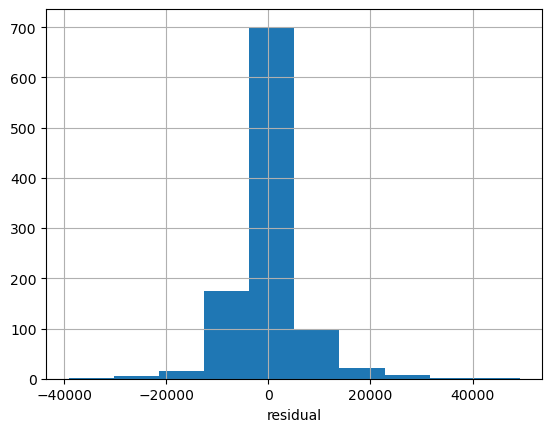

In [65]:
df_model['residual'].hist()
plt.xlabel('residual')
plt.show()

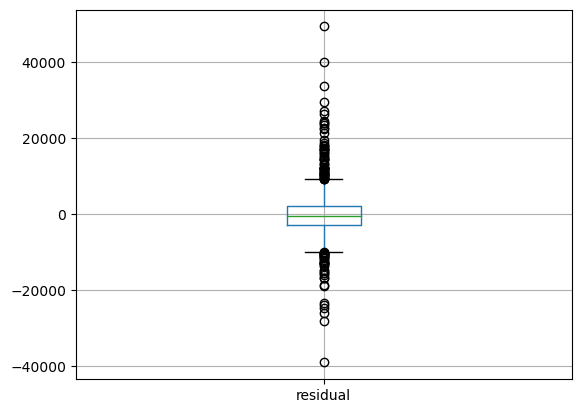

In [66]:
df_model.boxplot('residual')
plt.show()

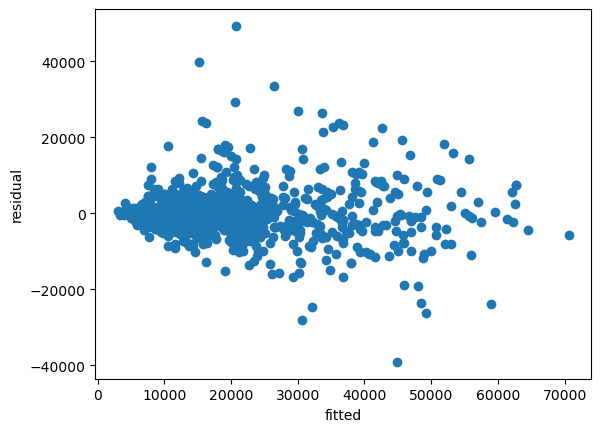

In [67]:
plt.scatter(x=df_model['pred'], y=df_model['residual'])
plt.xlabel('fitted')
plt.ylabel('residual')
plt.show()

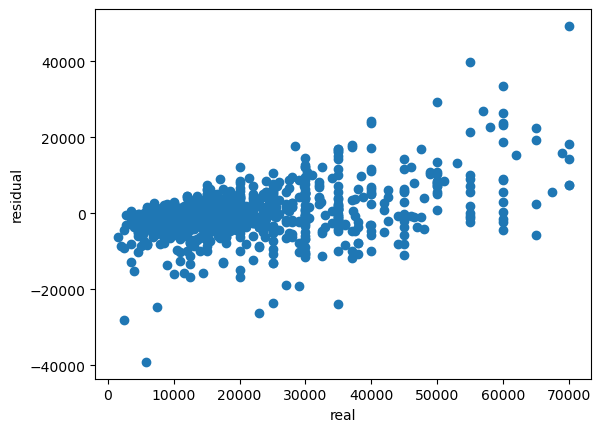

In [68]:
plt.scatter(x=df_model['true'], y=df_model['residual'])
plt.xlabel('real')
plt.ylabel('residual')
plt.show()